In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PreProcessing/PyScript')
import readdata

In [9]:
path = "/Users/ajc/Core/simulations/projections/climate_scenarios/"

#outfile ='/Users/ajc/Core/PostProcessing/barrow_watershed/2021/February/'

In [10]:
colors = ['r','b','grey','darkgreen','k']
marks = ['.','*', '+', 'o']
marks = ['-','-','-','-','-']

Labels = ['DW','WW','WC']
SimLabels = ['S%s'%i for i in range(3,0,-1)]

In [26]:
S1 = [os.path.join(path, 'CESM_01/CESM_5050_R1%s'%i) for i in range(1)] 
S2 = [os.path.join(path, 'CESM_01/CESM_5050_R2%s'%i) for i in range(2)] 

S3 = [os.path.join(path, 'CESM_01/CESM_5050_R3%s'%i) for i in range(2)]


Simulations = [S1, S2, S3]


sim_len = len(Simulations)
print (Simulations[2],sim_len)

['/Users/ajc/Core/simulations/projections/climate_scenarios/CESM_01/CESM_5050_R30', '/Users/ajc/Core/simulations/projections/climate_scenarios/CESM_01/CESM_5050_R31'] 3


In [27]:
#path_sf ="/Users/ajc/Core/simulations/projections/barrow_watershed_02/CESM_15/CESM_5050_R60_B/visdump_surface_star_data.h5"
#file_surf= h5py.File(path_sf,'r')

surface_area = 112635.47903126487 
#np.sum(list(file_surf['surface_star-cell_volume.cell.0']['100095']))
print (surface_area)
molar_density = 55500.

112635.47903126487


In [28]:
def get_vars_names():
    names = dict()
    file = os.path.join(Simulations[0][0],'data_collection.dat')
    with open(file) as fd:
        count = 0
        for f in fd:
            if ('Observation Name' in f):
                f1 = f.split(':')
                #print (f1, f[-1])
                if 'time [d]' in f1[-1]:
                    names['Time'] = count
                    #print (f1, f1[-1],names)
                elif 'outlet discharge [mol d^-1]' in f1[-1]:
                    names['Discharge'] = count 
                elif 'total evaporation [m d^-1]' in f1[-1]:
                    names['ET'] = count
                elif 'snow precipitation [m d^-1]' in f1[-1]:
                    names['Psnow'] = count
                elif 'rain precipitation [m d^-1]' in f1[-1]:
                    names['Prain'] = count
                elif 'subsurface water content [mol]' in f1[-1]:
                    names['SS_wc'] = count
                    #print (count)
                elif 'surface water content [mol]' in f1[-1]:
                    #print (count)
                    names['Sf_wc'] = count
                elif 'snow water content [mol]' in f1[-1]: #but this is in m^3 correction
                    names['Snow_wc'] = count
                elif 'surface air temperature [K]' in f1[-1]:
                    names['Tair'] = count
                elif 'surface carbon decomposition rate [-]' in f1[-1]:
                    names['Sf_CDR'] = count
                elif 'surface moisture content [-]' in f1[-1]:
                    names['Sf_mc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface volumetric wc [-]' in f1[-1]:
                    names['Sf_vol_wc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface column average temperature [K]' in f1[-1]:
                    names['Sf_avg_T'] = count
                elif 'surface ALT average temperature [K]' in f1[-1]:
                    names['Sf_ALT_avg_T'] = count
                elif 'surface saturated_fraction [-]' in f1[-1]:
                    names['Sf_sat_frac'] = count
                else:
                    print ('DNE:',count, f[-1])
                count = count + 1
    return names

In [29]:
names = get_vars_names()

In [30]:
def get_moving_average(d, m=5):
    d_avg = []
    len1 = len(d)
    for i in range(len1):
        if i < m:
            s1 = np.mean(d[:i+1])
        else:
            s1= np.mean(d[i-m:i])

        d_avg.append(s1)
    return d_avg

In [31]:
#Read discharge

time = 2006 + np.linspace(0,94,94,dtype='int')
to_day_mm = 86400 * 1000
to_year_mm = 86400 * 365 * 1000
basin_area = 112635.48
to_mm = 1000.

In [32]:

def get_daily_data():
    daily = dict()
    for i,sim in enumerate(Simulations):
        df = pd.DataFrame(columns=names.keys())
        #df.columns = names.keys()
        
        for s in sim:
            file = os.path.join(s,'data_collection.dat')
            df1 = pd.read_csv(file, comment='#')
            df1.columns = names.keys()
            rows,cols = df1.shape
            rows = rows - rows%365.
            df1 = df1.truncate(before=0,after=rows-1,axis='index')
            
            df = df.append(df1)
            #print (df)
        daily[SimLabels[i]] = df
        
    return daily

SimData_daily = get_daily_data()

In [33]:
#print (SimData_daily)
to_year = 365
to_mm = 1000
def get_discharge():
    Q_daily = dict()
    Q_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        d = [x* convert for x in SimData_daily[keys[i]]['Discharge'] ]
        Q_daily[keys[i]]= d*to_mm
        #print (d.shape)
        Q_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Q_daily, Q_annual
Q_daily, Q_annual = get_discharge()

def get_Pr():
    Pr_daily = dict()
    Pr_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Prain'] ]
        Pr_daily[keys[i]]= d*to_mm
        Pr_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Pr_daily, Pr_annual
Pr_daily, Pr_annual = get_Pr()


def get_Ps():
    Ps_daily = dict()
    Ps_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Psnow'] ]
        Ps_daily[keys[i]]= d*to_mm
        Ps_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Ps_daily, Ps_annual
Ps_daily, Ps_annual = get_Ps()

def get_time():
    T_daily = dict()
    T_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1./(365)
        d = [1985 + x* convert for x in SimData_daily[keys[i]]['Time'] ]
        T_daily[keys[i]]= d
        T_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return T_daily, T_annual
T_daily, T_annual = get_time()

dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']
dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']


In [34]:
def get_ET():
    ET_daily = dict()
    ET_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['ET'] ]
        ET_daily[keys[i]]= d*to_mm
        ET_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ET_daily, ET_annual
ET_daily, ET_annual = get_ET()

In [35]:
def get_Storage():
    ST_daily = dict()
    ST_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        ss_d = [x * convert for x in SimData_daily[keys[i]]['SS_wc'] ] #moles --> m
        sf_d = [x * convert for x in SimData_daily[keys[i]]['Sf_wc'] ] #moles --> m
        snow_d = [x /surface_area for x in SimData_daily[keys[i]]['Snow_wc'] ] #m^3 --> m
        d = [x+y+z for x,y,z in zip(ss_d, sf_d,snow_d)]
        ST_daily[keys[i]]= d*to_mm
        ST_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ST_daily, ST_annual
ST_daily, ST_annual = get_Storage()

In [36]:
def get_Carbon():
    CDR_daily = dict()
    CDR_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1#/(molar_density*surface_area)
        d = [x * convert for x in SimData_daily[keys[i]]['Sf_CDR'] ] 
        CDR_daily[keys[i]]= d#*to_mm
        CDR_annual[keys[i]]= np.reshape(d,(-1,365)).sum(axis=1)#*to_year #* to_mm
    return CDR_daily, CDR_annual
CDR_daily, CDR_annual = get_Carbon()



In [78]:
fig = plt.figure(figsize=(8,4))
for i in range(sim_len):
    s = SimLabels[i]
    d = get_moving_average(Q_annual[s],m=5)
    d = np.cumsum(Q_annual[s])
    #d=d/d[0]
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
    

plt.legend()
plt.ylabel('Mean annual discharge [mm]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
#plt.ylim(0,200)
plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-Q.pdf', bbox_inches='tight', dpi=500)



(2006.5, 2099.5)

In [82]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    d = get_moving_average(ET_annual[s])
    #d = [ (x - d[0])/d[0]*100 for x in d]
    #d = np.cumsum(ET_annual[s])
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
    
plt.legend()
plt.ylabel('Annual average ET [mm]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
#plt.ylim(100,400)
plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-ET.pdf', bbox_inches='tight', dpi=500)

(2006.5, 2099.5)

(2006.5, 2099.5)

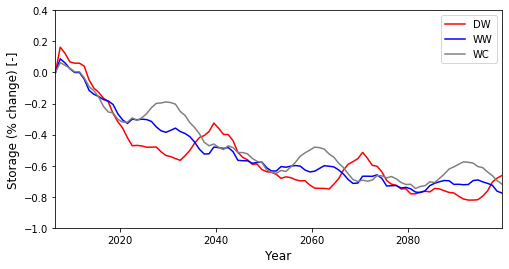

In [40]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    #d = [ (x - ST_annual[s][0])/ST_annual[s][0]*100 for x in ST_annual[s]]
    #d = get_moving_average(d)
    d = get_moving_average(ST_annual[s])
    d = [ (x - d[0])/d[0]*100 for x in d]
    #d = [ x/d[0] for x in d]
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Storage (% change) [-]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
plt.ylim(-1.0,0.4)
plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-storage.pdf', bbox_inches='tight', dpi=500)

In [73]:
%matplotlib qt
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    #d = get_moving_average(CDR_annual[s],m=5)
    #d = d/d[0]
    #plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
    d = np.cumsum(CDR_annual[s])
    #d = d/d[0]
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Carbon decomposition rate [-]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
#plt.ylim(0,25)
plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-CDR.pdf', bbox_inches='tight', dpi=500)

(2006.5, 2099.5)